# Bibliotecas


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Carregamento dos dados e Normalização


In [ ]:
train_df = pd.read_csv("fashion-mnist_train.csv.zip")
test_df  = pd.read_csv("fashion-mnist_test.csv.zip")

x_train = train_df.iloc[:, 1:].values.astype("float32") / 255.0
x_test  = test_df.iloc[:, 1:].values.astype("float32") / 255.0

# Denoising Autoencoder (fully connected)

Epoch 1/15, Loss: 0.0337
Epoch 2/15, Loss: 0.0269
Epoch 3/15, Loss: 0.0238
Epoch 4/15, Loss: 0.0219
Epoch 5/15, Loss: 0.0207
Epoch 6/15, Loss: 0.0211
Epoch 7/15, Loss: 0.0203
Epoch 8/15, Loss: 0.0190
Epoch 9/15, Loss: 0.0182
Epoch 10/15, Loss: 0.0177
Epoch 11/15, Loss: 0.0181
Epoch 12/15, Loss: 0.0172
Epoch 13/15, Loss: 0.0172
Epoch 14/15, Loss: 0.0172
Epoch 15/15, Loss: 0.0169


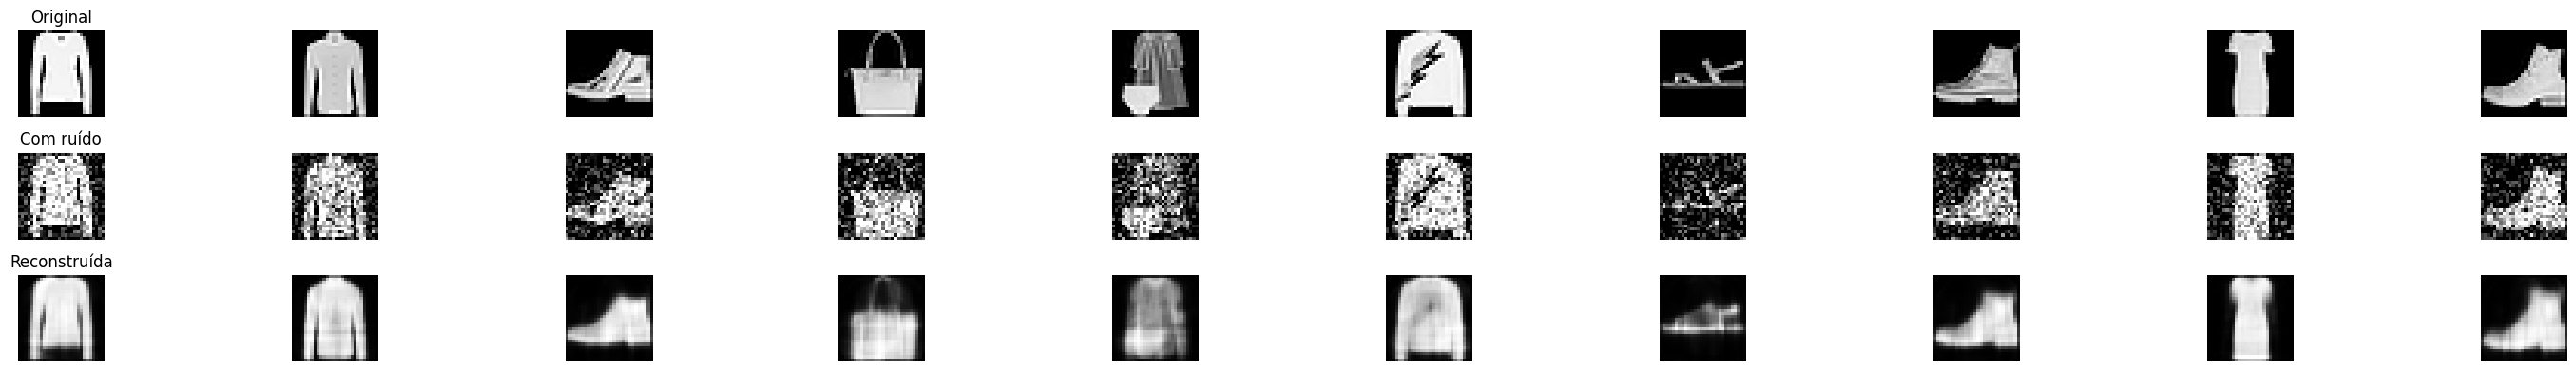

In [ ]:
# 1) Função para adicionar ruído (Gaussiano)
# =======================
def add_noise(X, noise_factor=0.3):
    X_noisy = X + noise_factor * np.random.randn(*X.shape)
    X_noisy = np.clip(X_noisy, 0., 1.)
    return X_noisy

# =======================
# 2) Inicialização de pesos
# =======================
def init_weights(in_dim, out_dim):
    return np.random.randn(in_dim, out_dim) * 0.01, np.zeros(out_dim)

input_dim = 28*28
latent_dim = 100

W_enc, b_enc = init_weights(input_dim, latent_dim)
W_dec, b_dec = init_weights(latent_dim, input_dim)

# =======================
# 3) Funções de ativação e gradiente
# =======================
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)

def mse_grad(x, x_hat):
    return 2 * (x_hat - x) / x.shape[0]

# =======================
# 4) Forward pass
# =======================
def forward(x, W_enc, b_enc, W_dec, b_dec):
    z_lin = np.dot(x, W_enc) + b_enc
    z = sigmoid(z_lin)
    x_hat_lin = np.dot(z, W_dec) + b_dec
    x_hat = sigmoid(x_hat_lin)
    return z, x_hat, z_lin, x_hat_lin

# =======================
# 5) Backpropagation
# =======================
def backward(x_clean, z, x_hat, z_lin, x_hat_lin, W_enc, b_enc, W_dec, b_dec, lr=0.1):
    grad_out = mse_grad(x_clean, x_hat) * sigmoid_deriv(x_hat_lin)
    dW_dec = np.dot(z.T, grad_out)
    db_dec = np.sum(grad_out, axis=0)
    grad_latent = np.dot(grad_out, W_dec.T) * sigmoid_deriv(z_lin)
    dW_enc = np.dot(x_clean.T, grad_latent)
    db_enc = np.sum(grad_latent, axis=0)

    W_enc -= lr * dW_enc
    b_enc -= lr * db_enc
    W_dec -= lr * dW_dec
    b_dec -= lr * db_dec

    return W_enc, b_enc, W_dec, b_dec

# =======================
# 6) Carregar os índices salvos da letra anterior (4-a)
# =======================
selected_idx = np.load("selected_idx.npy")
samples = x_test[selected_idx]

# =======================
# 7) Treinamento Denoising Autoencoder
# =======================
epochs = 15
batch_size = 128
train_loss_history = []

for epoch in range(epochs):
    perm = np.random.permutation(len(x_train))
    x_train_shuffled = x_train[perm]

    for i in range(0, len(x_train), batch_size):
        x_batch = x_train_shuffled[i:i+batch_size]
        x_noisy_batch = add_noise(x_batch, noise_factor=0.3)
        z, x_hat, z_lin, x_hat_lin = forward(x_noisy_batch, W_enc, b_enc, W_dec, b_dec)
        W_enc, b_enc, W_dec, b_dec = backward(x_batch, z, x_hat, z_lin, x_hat_lin,
                                              W_enc, b_enc, W_dec, b_dec, lr=0.1)
    _, x_hat_full, _, _ = forward(add_noise(x_train, 0.3), W_enc, b_enc, W_dec, b_dec)
    loss = np.mean((x_train - x_hat_full)**2)
    train_loss_history.append(loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

# =======================
# 8) Visualização das imagens
# =======================
samples_noisy = add_noise(samples, noise_factor=0.3)
_, recons, _, _ = forward(samples_noisy, W_enc, b_enc, W_dec, b_dec)

plt.figure(figsize=(3*len(samples), 4))
for i in range(len(samples)):
    # Original
    plt.subplot(3, len(samples), i+1)
    plt.imshow(samples[i].reshape(28,28), cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Original")

    # Com ruído
    plt.subplot(3, len(samples), len(samples)+i+1)
    plt.imshow(samples_noisy[i].reshape(28,28), cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Com ruído")

    # Reconstruída
    plt.subplot(3, len(samples), 2*len(samples)+i+1)
    plt.imshow(recons[i].reshape(28,28), cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Reconstruída")

plt.tight_layout()
plt.show()


# Avaliação Qualitativa


*  O autoencoder conseguiu recuperar a forma geral dos objetos (camisetas, bolsas, botas), preservando o contorno básico;

* Há uma perda de detalhes finos: contornos ficaram borrados e menos detalhados;

* A reconstrução ainda é muito melhor do que a imagem ruidosa, mostrando que o modelo aprendeu a ignorar parte significativa do ruído.
--------------------------------------------------------------------------------

A análise visual dos resultados evidencia que o autoencoder denoising apresentou desempenho satisfatório na remoção de ruído. As imagens originais, após sofrerem ação ruidosa, tornaram-se significativamente distorcidas, dificultando a identificação dos padrões visuais. Entretanto, as imagens reconstruídas pelo modelo recuperaram de forma consistente as formas globais e contornos principais dos objetos, o que demonstra a capacidade da rede em aprender representações robustas frente a ruídos. Observa-se, contudo, uma perda de detalhes finos e certa suavização nas reconstruções, resultando em imagens mais borradas em relação às originais. Ainda assim, a comparação entre as imagens ruidosas e reconstruídas evidencia a eficácia do modelo na tarefa de redução de ruído, reforçando a utilidade do autoencoder nesse contexto.

